In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections
import requests
import base64

from pandas.tools.plotting import scatter_matrix
import nltk
from ast import literal_eval
from datetime import timedelta
import string

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# create loader object
L = instaloader.Instaloader()

#Set PANDAS to show all columns in DataFrame
# pd.set_option('display.max_columns', None)
# plt.rcParams['figure.figsize'] = (15, 5)

UTC_FILE_NAME = "_UTC"
COMMENTS_FILE_NAME = "_comments"
FILE_ADDRESS_NAME = "InstagramLog/"


DONALD_TRUMP = 'realdonaldtrump'
DONALD_TRUMP_NAME = 'President Donald J. Trump'
DONALD_TRUMP_BIO = '45th President of the United States'
DONALD_TRUMP_COLOR = '#446fc4'
DONALD_TRUMP_TRAIN_SET = DONALD_TRUMP_NAME + DONALD_TRUMP + DONALD_TRUMP_BIO + 'president of the united state of america.'

BARACK_OBAMA = 'barackobama'
BARACK_OBAMA_NAME = 'Barack Obama'
BARACK_OBAMA_BIO = 'Dad, husband, President, citizen.'
BARACK_OBAMA_COLOR = '#7f2d9b'
BARACK_OBAMA_TRAIN_SET = BARACK_OBAMA + BARACK_OBAMA_NAME + BARACK_OBAMA_BIO + '44th President of the United States.'

EMMANUEL_MACRON = 'emmanuelmacron'
EMMANUEL_MACRON_NAME = 'Emmanuel Macron'
EMMANUEL_MACRON_BIO = 'Président de la République française.'
EMMANUEL_MACRON_COLOR = '#369b4f'
EMMANUEL_MACRON_TRAIN_SET = EMMANUEL_MACRON + EMMANUEL_MACRON_NAME + EMMANUEL_MACRON_BIO

#politicians
DONALD_TRUMP = 'realdonaldtrump'
BARACK_OBAMA = 'barackobama'
EMMANUEL_MACRON = 'emmanuelmacron'
THERESA_MAY = 'theresamay'
THERESA_MAY_COLOR = '#b7c631'
FLOTUS = 'flotus'

#news agencies
CNN = 'cnn'
FOXNEWS = 'foxnews'
BBC = 'bbcnews'
GOAL_COM = 'goalglobal' #sport

# sport stars
LEOMESSI = 'leomessi'
LEOMESSI_COLOR = '#e8d2d0'

CRISTIANO_RONALDO = 'cristiano'
CRISTIANO_RONALDO_COLOR = '#bec6c0'

RAFAEL_NADAL = 'rafaelnadal'
ROGER_FEDERER = 'rogerfederer'
NOVAK_DJOKOVIC = 'djokernole'

# sport clubs
REAL_MADRID = 'realmadrid'
FC_BARCELONA = 'fcbarcelona'


LIST_ALL_USERS = [DONALD_TRUMP , BARACK_OBAMA, EMMANUEL_MACRON, THERESA_MAY, FLOTUS, CNN, FOXNEWS, BBC, LEOMESSI, CRISTIANO_RONALDO,RAFAEL_NADAL ]

# MongoDB Database
instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
instagram_db = instagramClient["Instagram"]
instagram_col_post = instagram_db["Post"]
instagram_col_comment = instagram_db["Comment"]
instagram_col_like = instagram_db["Like"]
instagram_col_analyse = instagram_db["Analyse"]
instagram_col_mentioned_in_comment = instagram_db["MentionedInComment"]

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_excel('../Similarity/dataset_impersonator.xlsx')
print(df.shape[0])

3403


In [4]:
df.columns

Index(['owener_id', 'combined_shortcode_username', 'combined_username',
       'combined_full_name', 'combined_biography', 'combined_profile_pic_url',
       'combined_follower', 'combined_followee', 'combined_mediacount',
       'combined_owener_external_url', 'combined_is_verified',
       'combined_is_private', 'text', 'combined_similarity_username',
       'combined_similarity_full_name', 'combined_similarity_biography',
       'combined_similarity_photo'],
      dtype='object')

In [5]:
df.groupby('combined_shortcode_username').size()

combined_shortcode_username
barackobama          38
bbcnews               4
cristiano          2598
emmanuelmacron       29
flotus                6
foxnews              16
leomessi            398
rafaelnadal         189
realdonaldtrump     108
theresamay           17
dtype: int64

In [6]:
# df.columns
# df[['owener_id', 'combined_shortcode_username', 'total_comment', 'comment_created_at', 'comment_id',
#        'comment_post_shortcode', 'comment_shortcode_username', 'comment_text']]
df_dataset = df[[
        'combined_similarity_username', 
        'combined_similarity_full_name',
        'combined_similarity_biography',
        'combined_similarity_photo',


    'combined_follower',     
    'combined_followee',
    'combined_mediacount',
    'combined_is_private',
    'combined_is_verified', 

#        'comment_created_at', 'comment_id', 'comment_post_shortcode',
#        'comment_shortcode_username', 'comment_text', 
   
   ]]

df_dataset.columns = ['username', 'name', 'bio', 'photo', 'follower', 'followee', 'mediacount', 'private', 'verified']
df_dataset['class'] = 'impersonator'

/home/koosha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
def calculate_least_common_metrics(_row):

    _row['lcm'] = 0
    
    if (_row['username'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['name'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['bio'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['photo'] > 0):
        _row['lcm'] =  1
        return _row
        
    return _row

df_dataset = df_dataset.apply(calculate_least_common_metrics, axis=1)

In [8]:
def calculate_most_common_metrics(_row):

    _row['mcm'] = 0
    
    if (_row['username'] > 0):
        _row['mcm'] = _row['mcm'] + 1
    
    if (_row['name'] > 0):
        _row['mcm'] = _row['mcm'] + 1
    
    if (_row['bio'] > 0):
        _row['mcm'] = _row['mcm'] + 1
        
    if (_row['photo'] > 0):
        _row['mcm'] = _row['mcm'] + 1
        
    return _row

df_dataset = df_dataset.apply(calculate_most_common_metrics, axis=1)

In [9]:
#boolean to int
df_dataset[['private', 'verified']] = df_dataset[['private', 'verified']].astype(int)

In [10]:
#reorder
df_dataset = df_dataset[['username', 'name', 'bio', 'photo', 'follower', 'followee', 'mediacount', 'private', 'verified', 'lcm', 'mcm', 'class']]
# df_dataset = df_dataset[['follower', 'followee', 'mediacount', 'private', 'verified', 'lcm', 'mcm', 'class']]

In [11]:
df_dataset.dtypes

username      float64
name          float64
bio           float64
photo           int64
follower        int64
followee        int64
mediacount      int64
private         int64
verified        int64
lcm             int64
mcm             int64
class          object
dtype: object

In [12]:
df_dataset.head()

username      name       bio  photo  follower  followee  mediacount  \
0  0.000000  0.379978  0.000000      0         0         2           0   
1  0.000000  0.379978  0.000000      1         8        17          26   
2  0.317107  0.317107  0.279828      0        27        18          10   
3  0.000000  0.000000  0.317107      0        51        37           2   
4  0.000000  0.379978  0.000000      1        64        36          95   

   private  verified  lcm  mcm         class  
0        0         0    1    1  impersonator  
1        1         0    1    2  impersonator  
2        0         0    1    3  impersonator  
3        0         0    1    1  impersonator  
4        0         0    1    2  impersonator

In [13]:
# df_dataset.to_csv("out.csv", index=False)

In [14]:
crawled_like_ordinary = list(instagram_col_like.find( {
            "$and":
            [ 
                {'similarity_username': { '$eq': 0 }},
                {'similarity_full_name': { '$eq': 0 }},
                {'similarity_biography': { '$eq': 0 }},
                {'similarity_username' : { '$eq': 0 }}, 
            ]
        }
        ,{ 'similarity_biography': 1, 
            'similarity_full_name' : 1,
            'similarity_username' : 1, 
            'owener_followees' : 1,
            'owener_followers' : 1, 
            'owener_is_private' : 1,
            'owener_is_verified': 1, 
            'owener_mediacount' : 1}

        ).limit(3000))

df_ordinary =  pd.DataFrame(crawled_like_ordinary)
df_ordinary = df_ordinary[['similarity_username', 'similarity_full_name', 'similarity_biography',
                          'owener_followers', 'owener_followees', 'owener_mediacount', 'owener_is_private', 'owener_is_verified'
                         ]]

df_ordinary.columns = ['username', 'name', 'bio', 'follower', 'followee', 'mediacount', 'private', 'verified']
df_ordinary['photo'] = 0
df_ordinary['lcm'] = 0
df_ordinary['mcm'] = 0
df_ordinary['class'] = 'normal'
df_ordinary[['private', 'verified']] = df_ordinary[['private', 'verified']].astype(int)

# df_ordinary = df_ordinary[['follower', 'followee', 'mediacount', 'private', 'verified', 'lcm', 'mcm', 'class']]
df_ordinary = df_ordinary[['username', 'name', 'bio', 'photo', 'follower', 'followee', 'mediacount', 'private', 'verified', 'lcm', 'mcm', 'class']]

df_ordinary.head()

username  name  bio  photo  follower followee  mediacount  private  \
0       0.0   0.0  0.0      0       111                   54        1   
1       0.0   0.0  0.0      0        74                    0        1   
2       0.0   0.0  0.0      0        26                    0        1   
3       0.0   0.0  0.0      0       245                   14        1   
4       0.0   0.0  0.0      0       277                   23        0   

   verified  lcm  mcm   class  
0         0    0    0  normal  
1         0    0    0  normal  
2         0    0    0  normal  
3         0    0    0  normal  
4         0    0    0  normal

In [15]:
#remove empty followee rows!
df_ordinary['followee'].replace('', np.nan, inplace=True)
df_ordinary= df_ordinary.dropna(subset=['followee'])

In [16]:
df_ordinary.dtypes

username      float64
name          float64
bio           float64
photo           int64
follower        int64
followee      float64
mediacount      int64
private         int64
verified        int64
lcm             int64
mcm             int64
class          object
dtype: object

In [17]:
df_total = pd.concat([df_dataset, df_ordinary], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [18]:
df_total.shape

(6393, 12)

In [19]:
df_total.groupby('class').size()

class
impersonator    3403
normal          2990
dtype: int64

In [20]:
df_total.describe()

username         name          bio        photo      follower  \
count  6393.000000  6393.000000  6393.000000  6393.000000  6.393000e+03   
mean      0.077934     0.129373     0.130991     0.110277  5.217008e+03   
std       0.173259     0.267459     0.212635     0.313259  1.346919e+05   
min       0.000000     0.000000     0.000000     0.000000  0.000000e+00   
25%       0.000000     0.000000     0.000000     0.000000  8.000000e+01   
50%       0.000000     0.000000     0.000000     0.000000  2.220000e+02   
75%       0.000000     0.000000     0.303216     0.000000  5.960000e+02   
max       1.000000     1.000000     1.000000     1.000000  7.650215e+06   

          followee    mediacount      private     verified          lcm  \
count  6393.000000   6393.000000  6393.000000  6393.000000  6393.000000   
mean    535.592054    165.806507     0.425153     0.000939     0.532301   
std    1001.352844    805.991682     0.494405     0.030623     0.498995   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%      96.000000      7.000000     0.000000     0.000000     0.000000   
50%     245.000000     27.000000     0.000000     0.000000     1.000000   
75%     534.000000    109.000000     1.000000     0.000000     1.000000   
max    7508.000000  45057.000000     1.000000     1.000000     1.000000   

               mcm  
count  6393.000000  
mean      0.881276  
std       1.042652  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       4.000000

In [21]:
df_total.head()

username      name       bio  photo  follower  followee  mediacount  \
0  0.000000  0.379978  0.000000      0         0       2.0           0   
1  0.000000  0.379978  0.000000      1         8      17.0          26   
2  0.317107  0.317107  0.279828      0        27      18.0          10   
3  0.000000  0.000000  0.317107      0        51      37.0           2   
4  0.000000  0.379978  0.000000      1        64      36.0          95   

   private  verified  lcm  mcm         class  
0        0         0    1    1  impersonator  
1        1         0    1    2  impersonator  
2        0         0    1    3  impersonator  
3        0         0    1    1  impersonator  
4        0         0    1    2  impersonator

In [23]:
# normalize 
column_names_to_normalize = ['follower']#, 'followee', 'mediacount']
x = df_total[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_total['nfollower'] = x_scaled

column_names_to_normalize = ['followee']#, 'followee', 'mediacount']
x = df_total[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_total['nfollowee'] = x_scaled


column_names_to_normalize = ['mediacount']#, 'followee', 'mediacount']
x = df_total[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_total['nmediacount'] = x_scaled

/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
df_final = df_total[['username', 'name', 'bio', 'photo', 'nfollower', 'nfollowee', 'nmediacount', 'private', 'verified', 'lcm', 'mcm', 'class']]
df_final.head()

username      name       bio  photo  nfollower  nfollowee  nmediacount  \
0  0.000000  0.379978  0.000000      0   0.000000   0.000266     0.000000   
1  0.000000  0.379978  0.000000      1   0.000001   0.002264     0.000577   
2  0.317107  0.317107  0.279828      0   0.000004   0.002397     0.000222   
3  0.000000  0.000000  0.317107      0   0.000007   0.004928     0.000044   
4  0.000000  0.379978  0.000000      1   0.000008   0.004795     0.002108   

   private  verified  lcm  mcm         class  
0        0         0    1    1  impersonator  
1        1         0    1    2  impersonator  
2        0         0    1    3  impersonator  
3        0         0    1    1  impersonator  
4        0         0    1    2  impersonator

In [ ]:
from sklearn.cluster import KMeans
df_kmean = df_total[['username', 'name', 'bio', 'photo', 'nfollower', 'nfollowee', 'nmediacount', 'private', 'verified', 'lcm', 'mcm']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_kmean)
kmeans.labels_

In [ ]:
# df_final.to_csv("dataset_total_0504.csv", index=False)

In [38]:
# Split-out validation dataset
array = df_final.values
X = array[:,0:11]
Y = array[:,11]
validation_size = 0.30
seed = 11
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [39]:
# Test options and evaluation metric
seed = 11
scoring = 'accuracy'

In [40]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 1.000000 (0.000000)


/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/koosha/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

LDA: 0.972742 (0.017361)
KNN: 1.000000 (0.000000)
CART: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
SVM: 1.000000 (0.000000)


In [29]:
df_results = pd.DataFrame(results)
df_results = df_results.transpose()
df_results.columns = names
df_results.describe()

LR        LDA   KNN  CART    NB   SVM
count  10.0  10.000000  10.0  10.0  10.0  10.0
mean    1.0   0.965781   1.0   1.0   1.0   1.0
std     0.0   0.010154   0.0   0.0   0.0   0.0
min     1.0   0.947162   1.0   1.0   1.0   1.0
25%     1.0   0.961408   1.0   1.0   1.0   1.0
50%     1.0   0.963867   1.0   1.0   1.0   1.0
75%     1.0   0.970200   1.0   1.0   1.0   1.0
max     1.0   0.984344   1.0   1.0   1.0   1.0

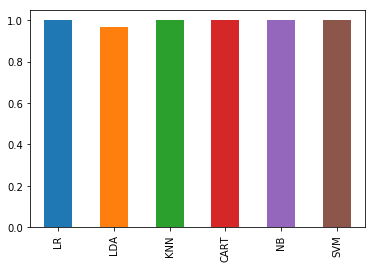

In [30]:
df_results.mean().plot(kind='bar')

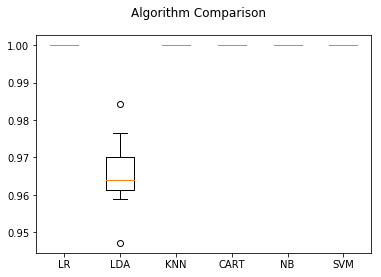

In [31]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [32]:
# Make predictions on validation dataset
knn = KNeighborsClassifier()
# knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[710   0]
 [  0 569]]
              precision    recall  f1-score   support

impersonator       1.00      1.00      1.00       710
      normal       1.00      1.00      1.00       569

 avg / total       1.00      1.00      1.00      1279



In [33]:
CART = DecisionTreeClassifier()
CART.fit(X_train, Y_train)
predictions = CART.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[710   0]
 [  0 569]]
              precision    recall  f1-score   support

impersonator       1.00      1.00      1.00       710
      normal       1.00      1.00      1.00       569

 avg / total       1.00      1.00      1.00      1279



In [34]:
LR = LogisticRegression(solver='liblinear', multi_class='ovr')
LR.fit(X_train, Y_train)
predictions = LR.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[710   0]
 [  0 569]]
              precision    recall  f1-score   support

impersonator       1.00      1.00      1.00       710
      normal       1.00      1.00      1.00       569

 avg / total       1.00      1.00      1.00      1279



Text(0,0.5,'Testing Accuracy')

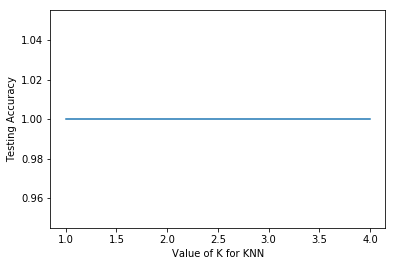

In [35]:
k_range = range(1,5)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,Y_train)
        y_pred=knn.predict(X_validation)
        scores[k] = accuracy_score(Y_validation,y_pred)
        scores_list.append(accuracy_score(Y_validation,y_pred))
        
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')